# Integrating PBMCs

## Imports

In [ ]:
import matplotlib.pyplot as plt
import muon as mu
import scanpy as sc

import mowgli

## Load data

Load the preprocessed PBMC dataset from 10X Genomics (scRNA-seq + scATAC-seq). You can download the dataset from https://figshare.com/s/4c8e72cbb188d8e1cce8

In [2]:
mdata = mu.read_h5mu("pbmc_preprocessed.h5mu.gz")

For computational reasons, in this demonstration we reduce the number of features and subsample the cells.

In [3]:
sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=800)
sc.pp.highly_variable_genes(mdata["atac"], n_top_genes=800)

In [4]:
# Perform the subsampling.
sc.pp.subsample(mdata["rna"], n_obs=500, random_state=0)
sc.pp.subsample(mdata["atac"], n_obs=500, random_state=0)

# Create a MuData object with rna and atac.
mdata = mu.MuData({"rna": mdata["rna"], "atac": mdata["atac"]})

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

In [5]:
# Reorder categories.
ordered_cat = [
    "CD56 (bright) NK cells",
    "CD56 (dim) NK cells",
    "MAIT T cells",
    "effector CD8 T cells",
    "naive CD8 T cells",
    "naive CD4 T cells",
    "memory CD4 T cells",
    "naive B cells",
    "memory B cells",
    "classical monocytes",
    "intermediate monocytes",
    "non-classical monocytes",
    "myeloid DC",
    "plasmacytoid DC",
]
mdata["rna"].obs["celltype"] = (
    mdata["rna"].obs["celltype"].cat.reorder_categories(ordered_cat)
)
mdata["atac"].obs["celltype"] = (
    mdata["atac"].obs["celltype"].cat.reorder_categories(ordered_cat)
)
mdata.obs["rna:celltype"] = mdata.obs["rna:celltype"].cat.reorder_categories(
    ordered_cat
)
mdata.obs["atac:celltype"] = mdata.obs["atac:celltype"].cat.reorder_categories(
    ordered_cat
)

In [6]:
# Umap RNA
sc.pp.scale(mdata["rna"], zero_center=False)
sc.tl.pca(mdata["rna"], svd_solver="arpack")
sc.pp.neighbors(mdata["rna"], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata["rna"], spread=1.5, min_dist=0.5)

In [7]:
# Umap ATAC
sc.pp.scale(mdata["atac"], zero_center=False)
sc.tl.pca(mdata["atac"], svd_solver="arpack")
sc.pp.neighbors(mdata["atac"], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata["atac"], spread=1.5, min_dist=0.5)

/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


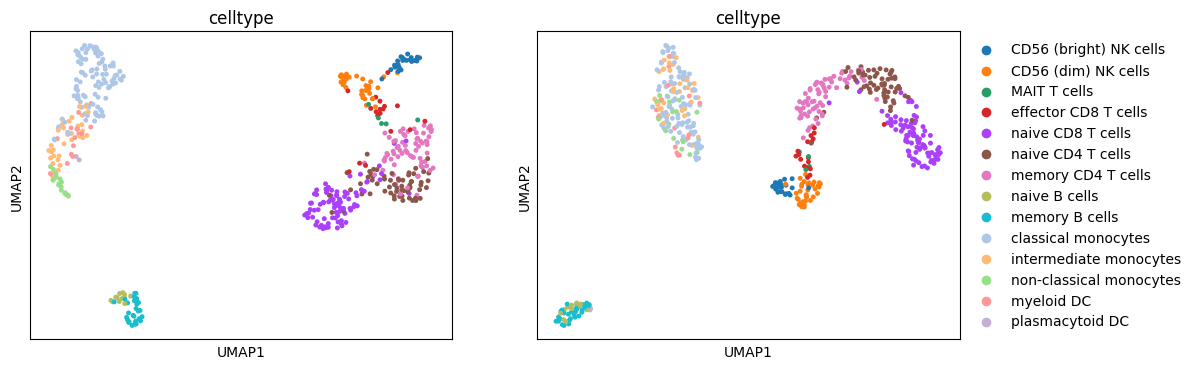

In [8]:
# Display UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sc.pl.umap(
    mdata["rna"], color="celltype", legend_loc="none", size=50, show=False, ax=axes[0]
)
sc.pl.umap(mdata["atac"], color="celltype", size=50, show=False, ax=axes[1])
plt.show()

## Train model

Let us define the model and perform the dimensionaly reduction.

In [9]:
# Define the model.
model = mowgli.models.MowgliModel(
    latent_dim=20,
    h_regularization=1e-2,
    w_regularization=1e-3,
    eps=0.1,
    cost="cosine",
)

In [27]:
# Perform the training.
model.train(mdata)

  3%|▎         | 6/200 [01:25<45:50, 14.18s/it, loss=0.04506588, loss_inner=-0.049072623, inner_steps=230, gpu_memory_allocated=0] 


## Visualize the embedding

Now, let us display the obtained embedding.

/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


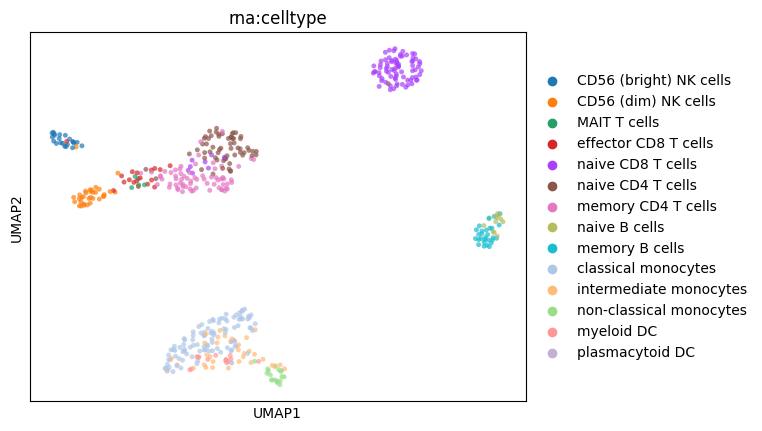

In [28]:
# First using a UMAP plot. This is pure Scanpy!
sc.pp.neighbors(mdata, use_rep="W_OT", key_added="mowgli")
sc.tl.umap(mdata, neighbors_key="mowgli")
sc.pl.umap(mdata, color="rna:celltype", size=50, alpha=0.7)

/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


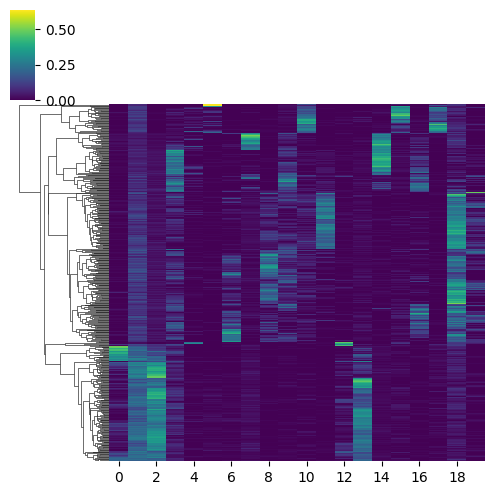

In [29]:
# Then using a dendogram.
mowgli.pl.clustermap(
    mdata,
    obsm="W_OT",
    yticklabels=False,
    figsize=(5, 5),
    col_cluster=False,
)

/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


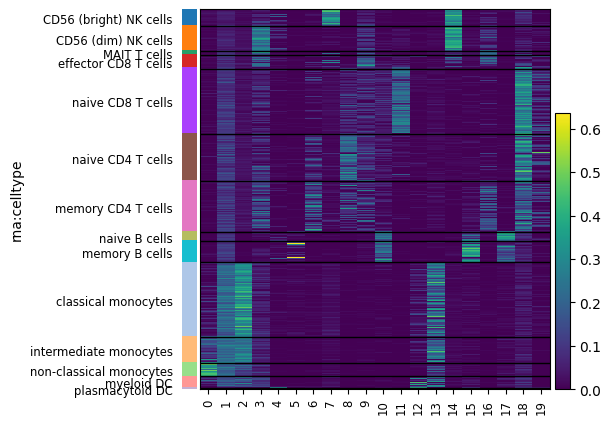

In [30]:
# Then, using a heatmap.
mowgli.pl.heatmap(
    mdata,
    obsm="W_OT",
    groupby="rna:celltype",
    figsize=(5, 5),
)

In [31]:
dim = 14

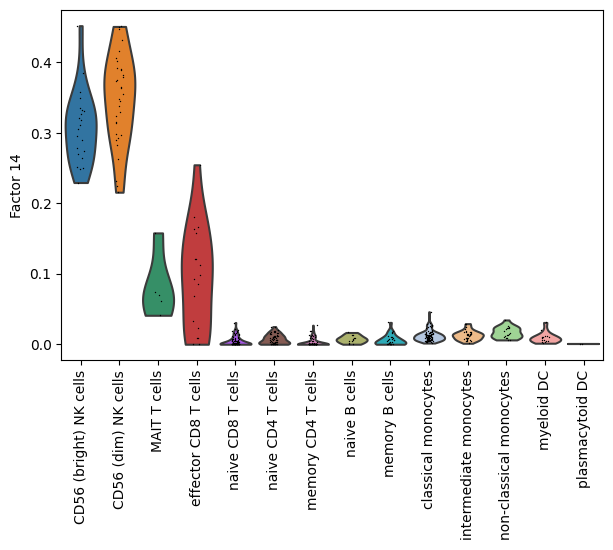

In [32]:
# Finally, display a violin plot of the value at a given dimension of the cells.
mowgli.pl.factor_violin(mdata, groupby="rna:celltype", dim=dim, rotation=90)

## Analyse a given factor

We can zoom in on a particular factor to interpret it biologically.

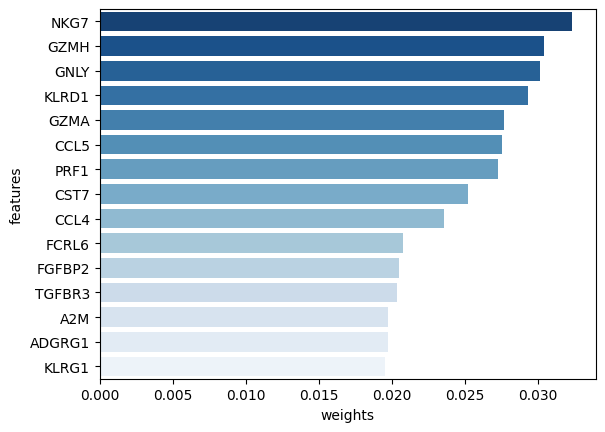

In [33]:
# Display the highest contributors to a given dimension, for RNA-seq.
mowgli.pl.top_features(mdata, mod="rna", uns="H_OT", dim=dim, n_top=15)

In [34]:
# Query g:profiler for Gene Set Enrichment Analysis, and display the results for a certain dimension.
enr, _ = mowgli.tl.enrich(
    mdata,
    mod="rna",
    n_genes=20,
    domain_scope="annotated",
)

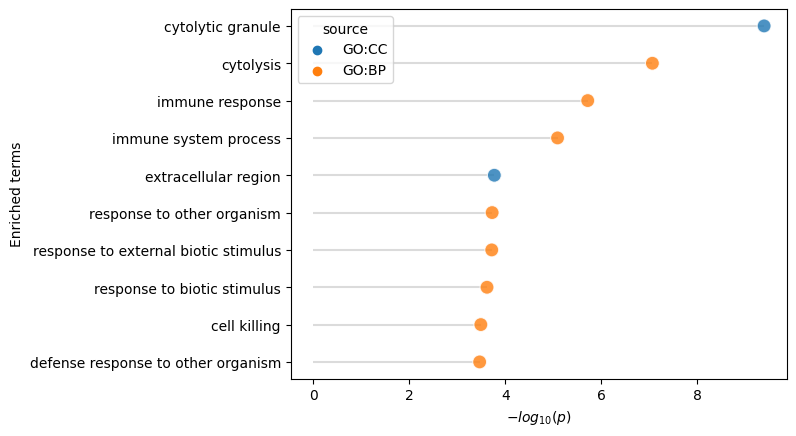

In [35]:
mowgli.pl.enrich(enr, f"dimension {dim}")

## Clustering

We can perform clustering on the lower-dimensional space.

/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/csb/huizing/anaconda3/envs/mowgli/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


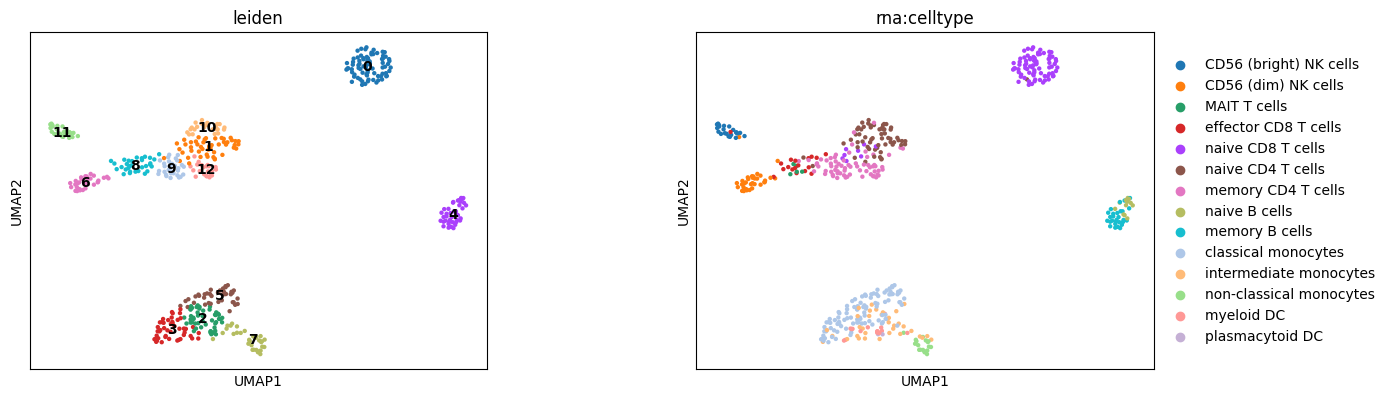

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=12.0)
sc.tl.leiden(mdata, resolution=1.5, neighbors_key="mowgli")
sc.pl.umap(mdata, color="leiden", legend_loc="on data", size=40, ax=axes[0], show=False)
sc.pl.umap(mdata, color="rna:celltype", size=40, ax=axes[1])